This notebook intersects a flood extent map (developed by Fabio Cian and Jose Manuel Delgado, based on Sentinel 1/2) with various data sources on population and infrastruture.

In [1]:
import rasterio as rio
import geopandas as gpd
import pandas as pd
import os, sys, glob
from osgeo import gdal
from rasterstats import zonal_stats
from rasterio.warp import reproject, Resampling
from shapely.geometry import box
from rasterio.mask import mask
import numpy as np
from rasterio import features
from shapely.geometry import shape, Polygon
from shapely.wkt import loads
from tqdm import tqdm
import geojson, json
import osmnx as ox
from affine import Affine
from matplotlib import pyplot as plt
from rasterio.plot import show

In [2]:
sys.path.append("/home/wb514197/Repos/INFRA_SAP")
import infrasap.rasterMisc as rMisc

In [3]:
data_dir = '/home/wb514197/data/south_sudan'

In [4]:
adm2 = os.path.join(data_dir, "SS_ADM2.shp")
flood_map1 = os.path.join(data_dir, "consolidated_maps", "Fusion_S1_S2", "flood_S1S2_fusion_noPermanentWater-1of2.tif")
flood_map2 = os.path.join(data_dir, "consolidated_maps", "Fusion_S1_S2", "flood_S1S2_fusion_noPermanentWater-1of2.tif")
# flood_map = os.path.join(data_dir, "SouthSudan_floodmap_S1_S2.tif")

In [5]:
flood_map = os.path.join(data_dir, "consolidated_maps", "Fusion_S1_S2", "flood_S1S2_fusion_noPermanentWater.vrt")

In [6]:
input_files = [flood_map1, flood_map2]

In [642]:
outds = gdal.BuildVRT(flood_map, input_files, separate=False, resolution='highest')

In [7]:
target = gpd.read_file(adm2)

In [8]:
target.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
flood = rio.open(flood_map)

In [10]:
flood_crs = flood.crs.to_string()

In [11]:
flood_crs

'EPSG:32636'

In [12]:
meta = flood.meta

In [13]:
flood.meta

{'driver': 'VRT',
 'dtype': 'uint8',
 'nodata': None,
 'width': 65536,
 'height': 48340,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(20.0, 0.0, -555340.0,
        0.0, -20.0, 1352720.0)}

In [14]:
flood_data = flood.read(1)

### GHSL PREP

In [111]:
ghsl_dir = os.path.join(data_dir, "ghsl", "built_multi")
input_files = glob.glob(ghsl_dir+"/*.tif")
out_vrt = os.path.join(ghsl_dir, input_files[0][0:-12]+".vrt")

In [114]:
outds = gdal.BuildVRT(out_vrt, input_files, separate=False, resolution='highest')

In [42]:
ghsl_dir = os.path.join(data_dir, "ghsl", "population")
input_files = glob.glob(ghsl_dir+"/*.tif")
out_vrt = os.path.join(ghsl_dir, input_files[0][0:-11]+".vrt")

In [73]:
outds = gdal.BuildVRT(out_vrt, input_files, separate=False, resolution='highest')

### Digitize Africa Prep

In [75]:
dig_dir = os.path.join(data_dir, "digitize_africa")

In [76]:
buildings_1 = gpd.read_file(os.path.join(dig_dir, "South_Sudan_UTM35N.shp"))

In [79]:
buildings_2 = gpd.read_file(os.path.join(dig_dir, "South_Sudan_UTM36N.shp"))

## 1. Area under flood

In [15]:
target = target.to_crs(flood_crs)

In [16]:
flood_dict = {
    0:'non-flooded',
    1:"flooded"
}

In [17]:
zs = pd.DataFrame(zonal_stats(target, flood_data, affine=meta['transform'], categorical=True, category_map=flood_dict))

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [18]:
area = target[['ADM2_EN','ADM1_EN_1','Area_km2','Area2']].join(zs)

In [19]:
area.loc[:,"cells"] = area['non-flooded']+area['flooded']

In [20]:
area.loc[:,'Area_Cells'] = area['cells']*0.0004

In [21]:
area.loc[:,'Area_Flooded'] = area['flooded']*0.0004

In [22]:
area.loc[:,'Area_Flooded_pct'] = area['Area_Flooded']/area['Area_Cells']

In [23]:
area.head()

,ADM2_EN,ADM1_EN_1,Area_km2,Area2,non-flooded,flooded,cells,Area_Cells,Area_Flooded,Area_Flooded_pct
0,Juba,Central Equatoria,18615.11000,18365.20,45782419,130435,45912854,18365.1416,52.1740,0.002841
1,Kajo-keji,Central Equatoria,2544.66280,2515.96,6287496,2373,6289869,2515.9476,0.9492,0.000377
2,Lainya,Central Equatoria,3542.07341,3501.75,8752257,2265,8754522,3501.8088,0.9060,0.000259
3,Morobo,Central Equatoria,1323.32522,1309.79,3274231,35,3274266,1309.7064,0.0140,0.000011
4,Terekeka,Central Equatoria,10848.42120,10673.80,26301502,382970,26684472,10673.7888,153.1880,0.014352


In [27]:
area.to_csv(os.path.join(out_folder, "area_flooded.csv"))

In [45]:
def standardizeInputRasters(inR1, inR2, data_type="N"):
    ''' Standardize inR1 to inR2: changes crs, extent, and resolution.
    Inputs:
    inR1, inR2 [rasterio raster object]
    inR1_outFile [string] - output file for creating inR1 standardized to inR2
    [optional] data_type [string ['C','N']]
    
    Returns:
    nothing
    '''
    if inR1.crs != inR2.crs:
        bounds = gpd.GeoDataFrame(pd.DataFrame([[1, box(*inR2.bounds)]], columns=["ID","geometry"]), geometry='geometry', crs=inR2.crs)
        bounds = bounds.to_crs(inR1.crs)
        b2 = bounds.total_bounds
        boxJSON = [{'type': 'Polygon', 'coordinates': [[[b2[0], b2[1]],[b2[0], b2[3]],[b2[2], b2[3]],[b2[2], b2[1]],[b2[0], b2[1]]]]}]
    else:
        b2 = inR2.bounds
        boxJSON = [{'type': 'Polygon', 'coordinates': [[[b2.left, b2.bottom],[b2.left, b2.top],[b2.right, b2.top],[b2.right, b2.bottom],[b2.left, b2.bottom]]]}]
    
    #Clip R1 to R2
    #Get JSON of bounding box
    out_img, out_transform = mask(inR1, boxJSON, crop=True)
    out_meta = inR1.meta.copy()
    #Re-scale resolution of R1 to R2
    newArr = np.empty(shape=(1, inR2.shape[0], inR2.shape[1]))
    
    if data_type == "N":
        resampling_type = Resampling.cubic
    elif data_type == "C":
        resampling_type = Resampling.nearest
    
    reproject(out_img, newArr, src_transform=out_transform, dst_transform=inR2.transform, src_crs=inR1.crs, dst_crs=inR2.crs, resampling=resampling_type)
    out_meta.update({"driver": "GTiff",
                     "height": newArr.shape[1],
                     "width": newArr.shape[2],
                     "transform": inR2.transform,
                     "crs": inR2.crs})
    
    return(newArr, out_meta)

In [69]:
out_folder = os.path.join(data_dir, "output")
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

## 2. Population affected

### LANDSCAN

In [30]:
landscan_dir = os.path.join(data_dir, "landscan")
landscan = rio.open(os.path.join(landscan_dir, "SS_LandScan_Population18.tif"))

In [31]:
landscan_crs = landscan.crs.to_string()

In [32]:
flood_re, flood_re_meta = standardizeInputRasters(flood, landscan, "C")

In [33]:
rMisc.standardizeInputRasters(flood, landscan, os.path.join(out_folder, "flood_landscan.tif"), data_type="C")

In [34]:
flood_re.shape

(1, 1050, 1416)

In [35]:
flood_lan = flood_re[0,:,:]

In [36]:
landscan_data = landscan.read(1)

In [37]:
flood_lan.shape == landscan_data.shape

True

In [38]:
pop_flooded = flood_lan*landscan_data

In [39]:
target = target.to_crs(landscan_crs)

In [40]:
zs_landscan = pd.DataFrame(zonal_stats(target, pop_flooded, affine=landscan.meta['transform'], stats='sum')).rename(columns = {'sum':'pop_affected_landscan'})

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [41]:
zs_landscan_tot = pd.DataFrame(zonal_stats(target, landscan_data, affine=landscan.meta['transform'], stats='sum')).rename(columns = {'sum':'pop_landscan'})

### GHSL

In [43]:
ghsl = rio.open(out_vrt)

In [44]:
ghsl_crs = ghsl.crs.to_string()

In [45]:
flood_re, flood_re_meta = standardizeInputRasters(flood, ghsl, "C")

In [46]:
flood_ghsl = flood_re[0,:,:]

In [47]:
ghsl_data = ghsl.read(1)

In [48]:
flood_ghsl.shape == ghsl_data.shape

True

In [49]:
pop_flooded = flood_ghsl*ghsl_data

In [50]:
target = target.to_crs(ghsl_crs)

In [51]:
zs_ghsl = pd.DataFrame(zonal_stats(target, pop_flooded, affine=ghsl.meta['transform'], stats='sum', nodata=-200)).rename(columns = {'sum':'pop_affected_ghsl'})

In [52]:
zs_ghsl_tot = pd.DataFrame(zonal_stats(target, ghsl_data, affine=ghsl.meta['transform'], stats='sum', nodata=-200)).rename(columns = {'sum':'pop_ghsl'})

### WORLD POP

In [53]:
wp_dir = os.path.join(data_dir, "worldpop")
wp_bespoke = rio.open(os.path.join(wp_dir, "bespoke", "SSD_population_v1_0_gridded.tif"))
wp = rio.open(os.path.join(wp_dir, "ssd_ppp_2020_UNadj.tif"))
wp_const = rio.open(os.path.join(wp_dir, "ssd_ppp_2020_UNadj_constrained.tif"))

In [54]:
wp_crs = wp.crs.to_string()

In [55]:
flood_re, flood_re_meta = standardizeInputRasters(flood, wp, "C")

In [56]:
flood_wp = flood_re[0,:,:]

In [58]:
wp_data = wp.read(1)
wp_bespoke_data = wp_bespoke.read(1)
wp_const_data = wp_const.read(1)

In [59]:
target = target.to_crs(wp_crs)

In [60]:
pop_flooded = flood_wp*wp_data

In [61]:
zs_wp = pd.DataFrame(zonal_stats(target, pop_flooded, affine=wp.meta['transform'], stats='sum', nodata=wp.meta['nodata'])).rename(columns = {'sum':'pop_affected_wp'})
zs_wp_tot = pd.DataFrame(zonal_stats(target, wp_data, affine=wp.meta['transform'], stats='sum', nodata=wp.meta['nodata'])).rename(columns = {'sum':'pop_wp'})

In [62]:
pop_flooded = flood_wp*wp_const_data

In [63]:
zs_wpcon = pd.DataFrame(zonal_stats(target, pop_flooded, affine=wp.meta['transform'], stats='sum', nodata=wp.meta['nodata'])).rename(columns = {'sum':'pop_affected_wpcon'})
zs_wpcon_tot = pd.DataFrame(zonal_stats(target, wp_const_data, affine=wp.meta['transform'], stats='sum', nodata=wp.meta['nodata'])).rename(columns = {'sum':'pop_wpcon'})

In [64]:
flood_re, flood_re_meta = standardizeInputRasters(flood, wp_bespoke, "C")

In [66]:
flood_wpbe = flood_re[0,:,:]

In [67]:
wp_bespoke_data[wp_bespoke_data<0] = 0

In [68]:
pop_flooded = flood_wpbe*wp_bespoke_data

In [69]:
zs_wpbe = pd.DataFrame(zonal_stats(target, pop_flooded, affine=wp_bespoke.meta['transform'], stats='sum', nodata=wp_bespoke.meta['nodata'])).rename(columns = {'sum':'pop_affected_wpbe'})
zs_wpbe_tot = pd.DataFrame(zonal_stats(target, wp_bespoke_data, affine=wp_bespoke.meta['transform'], stats='sum', nodata=wp_bespoke.meta['nodata'])).rename(columns = {'sum':'pop_wpbe'})

Gather all

In [70]:
res = [zs_landscan_tot, zs_landscan, zs_ghsl_tot, zs_ghsl, zs_wp_tot, zs_wp, zs_wpcon_tot, zs_wpcon, zs_wpbe_tot, zs_wpbe]

In [71]:
res = pd.concat(res, axis=1)

In [76]:
target[['Pop_2019','Pop_LS18']]

,Pop_2019,Pop_LS18
0,499538.0,1560637.0
1,221902.0,220220.0
2,110282.0,130344.0
3,104106.0,177956.0
4,246483.0,181620.0
...,...,...
73,71586.0,48714.0
74,22072.0,15273.0
75,81075.0,76253.0
76,110431.0,111084.0


In [77]:
pop = target[['ADM2_EN','ADM1_EN_1','Pop_2019','Pop_LS18']].join(res)

In [78]:
pop.to_csv(os.path.join(out_folder, "pop_flooded.csv"))

## 3. Buildings affected

In [314]:
buildings_1 = buildings_1.to_crs(buildings_2.crs)

In [315]:
buildings = pd.concat([buildings_1, buildings_2])

In [316]:
len(buildings_1)+len(buildings_2)==len(buildings)

True

In [748]:
len(buildings)

3706822

In [750]:
buildings.duplicated('OBJECTID').sum()

0

In [22]:
flood_mask = (flood_data==1)

In [23]:
allFeatures = []
idx = 0
for cShape, value in features.shapes(flood_data, mask=flood_mask, transform=flood.meta['transform']):
    allFeatures.append([idx, shape(geojson.loads(json.dumps(cShape)))])
    idx+=1

In [24]:
xx = pd.DataFrame(allFeatures, columns=['ID', 'geometry'])
xxGeom = gpd.GeoDataFrame(xx, geometry='geometry')
xxGeom.crs = flood.crs

<AxesSubplot:>

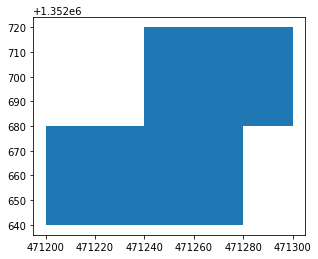

In [48]:
xxGeom.iloc[[0]].plot()

In [25]:
xxGeom.to_file(os.path.join(out_folder, "flood_bool.shp"), driver="ESRI Shapefile")

In [328]:
xxGeom.loc[:,"bool"] = 1

In [337]:
target = target.to_crs(xxGeom.crs)

In [457]:
row = target.iloc[0]

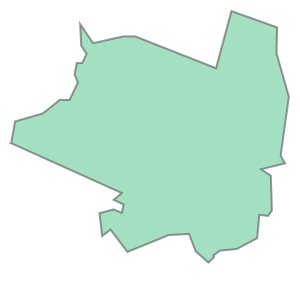

In [458]:
row.geometry

In [344]:
sindex_buildings = buildings.sindex
sindex_flood = xxGeom.sindex

In [356]:
polygon = row.geometry

In [357]:
%%time
possible_matches_buildings_index = list(sindex_buildings.intersection(polygon.bounds))
possible_matches_flood_index = list(sindex_flood.intersection(polygon.bounds))

CPU times: user 426 ms, sys: 28.9 ms, total: 455 ms
Wall time: 454 ms


In [351]:
# %%time
# buildings_filt_test = buildings[buildings.intersects(polygon)]

CPU times: user 24.6 s, sys: 1.57 s, total: 26.2 s
Wall time: 26.2 s


In [358]:
%%time
possible_matches_buildings = buildings.iloc[possible_matches_buildings_index]
possible_matches_flood = xxGeom.iloc[possible_matches_flood_index]

CPU times: user 387 ms, sys: 55 ms, total: 442 ms
Wall time: 440 ms


In [359]:
%%time
buildings_filt = possible_matches_buildings[possible_matches_buildings.intersects(polygon)]
flood_filt = possible_matches_flood[possible_matches_flood.intersects(polygon)]

CPU times: user 15.6 s, sys: 334 ms, total: 16 s
Wall time: 16 s


In [373]:
%%time
# buildings_flood = gpd.sjoin(buildings_filt, flood_filt, how='left', rsuffix="flood")

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 14.3 µs


In [370]:
len(buildings_filt)

335236

In [374]:
%%time
# buildings_filt.loc[buildings_filt.intersects(flood_filt.unary_union), "flooded"] = 1

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11.4 µs


In [335]:
# who knows how long this would take
# %%time
# buildings_flood = gpd.sjoin(buildings, xxGeom, how='left', rsuffix="flood")

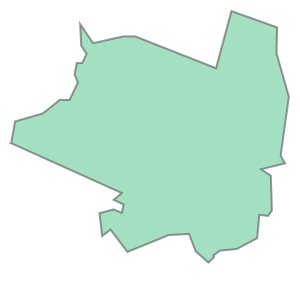

In [441]:
polygon

In [480]:
geom_cut = ox.utils_geo._quadrat_cut_geometry(polygon, 50000)

In [481]:
type(geom_cut)

shapely.geometry.multipolygon.MultiPolygon

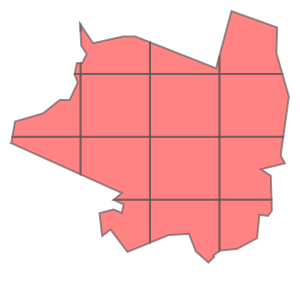

In [482]:
geom_cut

In [483]:
for poly in geom_cut:
    print(poly)

POLYGON ((400533.218836762 593402.1280940186, 400076.3860391852 576331.9083686342, 404025.4193658273 562564.3485974476, 362292.7085472428 562564.3485974476, 362292.7085472428 574711.2747647192, 370246.9246809689 604236.5759701725, 400533.218836762 593402.1280940186))
POLYGON ((404025.4193658273 562564.3485974476, 408330.9275880104 547554.0063462612, 404616.5299343935 520892.1212247228, 362292.7085472428 520892.1212247228, 362292.7085472428 562564.3485974476, 404025.4193658273 562564.3485974476))
POLYGON ((404616.5299343935 520892.1212247228, 402871.5105858498 508366.4011095301, 404494.036927794 505528.8460675557, 405752.1339450477 503328.8170194637, 389869.2688716584 499393.5658264993, 396359.4662589461 495069.9301492994, 396719.5318086474 483111.1247889074, 396836.8408121791 479219.893851998, 362292.7085472428 479219.893851998, 362292.7085472428 520892.1212247228, 404616.5299343935 520892.1212247228))
POLYGON ((396836.8408121791 479219.893851998, 397052.8220471471 472055.6282117029, 3

In [484]:
poly = loads("POLYGON ((316254.4895064752 479219.893851998, 316254.4895064752 520892.1212247228, 362292.7085472428 520892.1212247228, 362292.7085472428 479219.893851998, 316254.4895064752 479219.893851998))")

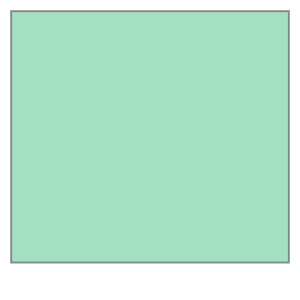

In [485]:
poly

In [486]:
%%time
possible_matches_buildings_index = list(sindex_buildings.intersection(poly.bounds))
possible_matches_flood_index = list(sindex_flood.intersection(poly.bounds))

possible_matches_buildings = buildings.iloc[possible_matches_buildings_index]
possible_matches_flood = xxGeom.iloc[possible_matches_flood_index]

buildings_filt = possible_matches_buildings[possible_matches_buildings.intersects(polygon)]
flood_filt = possible_matches_flood[possible_matches_flood.intersects(polygon)]

CPU times: user 158 ms, sys: 16.1 ms, total: 174 ms
Wall time: 173 ms


In [487]:
len(buildings_filt), len(flood_filt)

(3880, 354)

In [492]:
%%time
buildings_filt[buildings_filt.intersects(flood_filt.unary_union)]

CPU times: user 48.2 s, sys: 733 ms, total: 48.9 s
Wall time: 48.9 s


,OBJECTID,PolyDate,ImgDate,CAT_ID,DataSource,Product,Shape_Leng,Shape_Area,geometry
1112913,1112914,2019-08-14,2018-12-15,10400100454CF700,Ecopia Tech© Maxar©,Vivid 2.0,0.000371,6.801571e-09,"POLYGON ((355584.753 519611.309, 355596.756 51..."
1112845,1112846,2019-08-14,2018-12-15,10400100454CF700,Ecopia Tech© Maxar©,Vivid 2.0,0.000519,1.323597e-08,"POLYGON ((355562.247 519623.312, 355566.748 51..."
909576,909577,2019-08-14,2018-12-15,1040010047A4CC00,Ecopia Tech© Maxar©,Vivid 2.0,0.000305,5.299465e-09,"POLYGON ((343696.055 517720.501, 343698.001 51..."
909577,909578,2019-08-14,2018-12-15,1040010047A4CC00,Ecopia Tech© Maxar©,Vivid 2.0,0.000278,4.619361e-09,"POLYGON ((343717.608 517766.751, 343719.404 51..."
474865,474866,2019-08-14,2018-12-15,1040010047A4CC00,Ecopia Tech© Maxar©,Vivid 2.0,0.000195,2.528477e-09,"POLYGON ((339822.821 514439.760, 339825.322 51..."


In [493]:
%%time
buildings_flood = gpd.sjoin(buildings_filt, flood_filt, how='left', rsuffix="flood")

CPU times: user 993 ms, sys: 31.8 ms, total: 1.03 s
Wall time: 1.02 s


In [494]:
gpd.sjoin?

In [504]:
buildings_flood[buildings_flood['bool']==1]

,OBJECTID,PolyDate,ImgDate,CAT_ID,DataSource,Product,Shape_Leng,Shape_Area,geometry,index_flood,ID,bool
1112913,1112914,2019-08-14,2018-12-15,10400100454CF700,Ecopia Tech© Maxar©,Vivid 2.0,0.000371,6.801571e-09,"POLYGON ((355584.753 519611.309, 355596.756 51...",822403.0,822403.0,1.0
1112845,1112846,2019-08-14,2018-12-15,10400100454CF700,Ecopia Tech© Maxar©,Vivid 2.0,0.000519,1.323597e-08,"POLYGON ((355562.247 519623.312, 355566.748 51...",822403.0,822403.0,1.0
909576,909577,2019-08-14,2018-12-15,1040010047A4CC00,Ecopia Tech© Maxar©,Vivid 2.0,0.000305,5.299465e-09,"POLYGON ((343696.055 517720.501, 343698.001 51...",822539.0,822539.0,1.0
909577,909578,2019-08-14,2018-12-15,1040010047A4CC00,Ecopia Tech© Maxar©,Vivid 2.0,0.000278,4.619361e-09,"POLYGON ((343717.608 517766.751, 343719.404 51...",822539.0,822539.0,1.0
474865,474866,2019-08-14,2018-12-15,1040010047A4CC00,Ecopia Tech© Maxar©,Vivid 2.0,0.000195,2.528477e-09,"POLYGON ((339822.821 514439.760, 339825.322 51...",823074.0,823074.0,1.0


In [ ]:
buildings_filt[buildings_filt.intersects(flood_filt.geometry)]

In [16]:
target = target.to_crs(flood_crs)

In [55]:
adm0 = target.unary_union

In [56]:
geom_cut = ox.utils_geo._quadrat_cut_geometry(adm0, 50000)

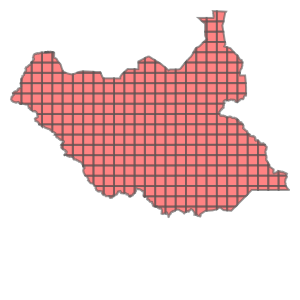

In [57]:
geom_cut

In [583]:
res = []

In [584]:
for i, poly in tqdm(enumerate(geom_cut)):
    
    possible_matches_buildings_index = list(sindex_buildings.intersection(poly.bounds))
    possible_matches_flood_index = list(sindex_flood.intersection(poly.bounds))

    possible_matches_buildings = buildings.iloc[possible_matches_buildings_index]
    possible_matches_flood = xxGeom.iloc[possible_matches_flood_index]

    buildings_filt = possible_matches_buildings[possible_matches_buildings.intersects(poly)]
    flood_filt = possible_matches_flood[possible_matches_flood.intersects(poly)]
    
    intersect = gpd.sjoin(buildings_filt, flood_filt, how='left', rsuffix="flood")
    res.append(intersect)

24it [18:47, 47.00s/it]


KeyboardInterrupt: 

In [585]:
len(buildings_filt), len(flood_filt)

(57329, 5157)

In [586]:
[len(r) for r in res]

[29113,
 29815,
 8954,
 9290,
 7204,
 10641,
 6171,
 4133,
 426,
 2100,
 2251,
 3823,
 12729,
 19553,
 56,
 17,
 0,
 7236,
 469,
 5103,
 10557,
 8736,
 15183,
 10904]

In [571]:
geom_cut = ox.utils_geo._quadrat_cut_geometry(poly, 10000)

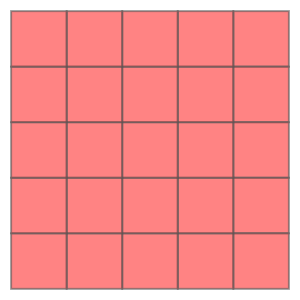

In [572]:
geom_cut

In [573]:
res2 = []

In [574]:
for i, pol in tqdm(enumerate(geom_cut)):
    
    possible_matches_buildings_index = list(sindex_buildings.intersection(pol.bounds))
    possible_matches_flood_index = list(sindex_flood.intersection(pol.bounds))

    possible_matches_buildings = buildings.iloc[possible_matches_buildings_index]
    possible_matches_flood = xxGeom.iloc[possible_matches_flood_index]

    buildings_filt = possible_matches_buildings[possible_matches_buildings.intersects(pol)]
    flood_filt = possible_matches_flood[possible_matches_flood.intersects(pol)]
    
    intersect = gpd.sjoin(buildings_filt, flood_filt, how='left', rsuffix="flood")
    res2.append(buildings_filt)

25it [00:24,  1.00it/s]


In [570]:
[len(r) for r in res2]

[0,
 144,
 1,
 408,
 3,
 210,
 1418,
 13786,
 66831,
 45124,
 17179,
 52439,
 328,
 175,
 0,
 0,
 12,
 4,
 0,
 0,
 1171,
 9518,
 255,
 20,
 8,
 0,
 0,
 0,
 0,
 0,
 595,
 1913,
 250,
 65,
 2,
 0,
 40,
 0,
 0,
 0,
 455,
 672,
 183,
 24,
 0,
 0,
 77,
 77,
 121,
 52,
 660,
 6,
 25,
 1,
 40,
 0,
 0,
 125,
 0,
 108,
 0,
 0,
 0,
 0,
 40,
 0,
 290,
 0,
 0,
 70,
 0,
 3,
 0,
 626,
 78,
 2,
 30,
 0,
 0,
 0,
 0,
 0,
 0,
 1092,
 8,
 0,
 0,
 0,
 46,
 134,
 0,
 608,
 8,
 278,
 0,
 0,
 0,
 0,
 263,
 197]

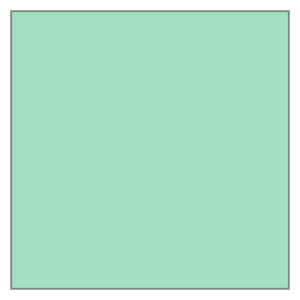

In [587]:
poly

In [588]:
len(buildings_filt)

57329

In [593]:
# get pixel coordinates of the geometry's bounding box
ul = flood.index(*poly.bounds[0:2])
lr = flood.index(*poly.bounds[2:4])
window = ((float(lr[0]), float(ul[0]+1)), (float(ul[1]), float(lr[1]+1)))
t = flood.transform
shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)

In [594]:
flood_window = flood.read(1, window=window)

In [601]:
flood_dict2 = {1:'flooded'}

In [602]:
%%time
zs = pd.DataFrame(zonal_stats(buildings_filt, flood_window, affine=shifted_affine, categorical=True, nodata = 0, category_map=flood_dict2))

CPU times: user 1min 3s, sys: 4.56 s, total: 1min 7s
Wall time: 1min 7s


In [606]:
len(buildings_filt)

57329

In [612]:
zs.fillna(0, inplace=True)

In [616]:
buildings_filt.reset_index(inplace=True)

In [618]:
buildings_filt = buildings_filt.join(zs)

In [691]:
res = []

In [692]:
for i, poly in tqdm(enumerate(geom_cut)):
    
    possible_matches_buildings_index = list(sindex_buildings.intersection(poly.bounds))
    possible_matches_buildings = buildings.iloc[possible_matches_buildings_index]
    buildings_filt = possible_matches_buildings[possible_matches_buildings.intersects(poly)]
    
    if len(buildings_filt) > 0:
        
        # get pixel coordinates of the geometry's bounding box
        ul = flood.index(*poly.bounds[0:2])
        lr = flood.index(*poly.bounds[2:4])
        window = ((float(lr[0]), float(ul[0]+1)), (float(ul[1]), float(lr[1]+1)))
        t = flood.transform
        shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)

        flood_window = flood.read(1, window=window)
        zs = pd.DataFrame(zonal_stats(buildings_filt, flood_window, affine=shifted_affine, categorical=True, nodata = 0, category_map=flood_dict2))
        zs.fillna(0, inplace=True)
        buildings_filt.reset_index(inplace=True)
        intersect = buildings_filt.join(zs)
        res.append(intersect)

348it [43:13,  7.45s/it]


In [695]:
results = pd.concat(res)

In [699]:
len(results)

3701899

In [658]:
a = [len(r) for r in res]

In [664]:
a.sort(reverse=True)

In [665]:
a

[217921,
 184017,
 110865,
 107032,
 93662,
 92829,
 92374,
 86226,
 80914,
 78797,
 69622,
 67065,
 66087,
 57329,
 54829,
 50487,
 48107,
 43077,
 41757,
 41655,
 40671,
 39540,
 38142,
 37895,
 36765,
 36526,
 34547,
 33504,
 33258,
 32651,
 31323,
 31075,
 30906,
 29924,
 29815,
 29113,
 28946,
 27788,
 27683,
 27270,
 27062,
 26020,
 25684,
 25115,
 24575,
 23333,
 22552,
 22544,
 21193,
 20875,
 20655,
 20346,
 19594,
 19550,
 19444,
 19214,
 19089,
 18492,
 18042,
 17954,
 17757,
 17302,
 17088,
 16456,
 16301,
 16294,
 16031,
 15877,
 15680,
 15579,
 15510,
 15199,
 15182,
 14942,
 13940,
 13717,
 13110,
 13099,
 12728,
 12630,
 12361,
 12150,
 11906,
 11898,
 11856,
 11388,
 10903,
 10641,
 10557,
 10525,
 10023,
 9995,
 9949,
 9739,
 9362,
 9326,
 9311,
 9290,
 8954,
 8736,
 8637,
 8417,
 8397,
 8324,
 7994,
 7982,
 7951,
 7706,
 7649,
 7596,
 7593,
 7331,
 7285,
 7236,
 7204,
 7160,
 7159,
 7007,
 6663,
 6326,
 6189,
 6171,
 6032,
 6009,
 5585,
 5425,
 5409,
 5406,
 5163,
 5

In [706]:
%%time
results2 = gpd.sjoin(results, target[['ADM2_EN', 'ADM1_EN', 'ADM2_PCODE', 'geometry']], how='left', rsuffix="admin")

CPU times: user 12min 31s, sys: 24.1 s, total: 12min 55s
Wall time: 12min 55s


In [707]:
results2.head()

,index,OBJECTID,PolyDate,ImgDate,CAT_ID,DataSource,Product,Shape_Leng,Shape_Area,geometry,flooded,index_admin,ADM2_EN,ADM1_EN,ADM2_PCODE
0,1298817,1298818,2019-08-14,2012-01-08,103001001042B300,Ecopia Tech© Maxar©,Vivid 2.0,0.000123,9.467356e-10,"POLYGON ((281229.150 431487.696, 281232.151 43...",0.0,2,Lainya,Central Equatoria,SS0103
1,1298823,1298824,2019-08-14,2012-01-08,103001001042B300,Ecopia Tech© Maxar©,Vivid 2.0,0.000134,1.143461e-09,"POLYGON ((281237.430 431492.448, 281238.860 43...",0.0,2,Lainya,Central Equatoria,SS0103
2,1298824,1298825,2019-08-14,2012-01-08,103001001042B300,Ecopia Tech© Maxar©,Vivid 2.0,0.000120,8.814246e-10,"POLYGON ((281219.854 431492.508, 281221.256 43...",0.0,2,Lainya,Central Equatoria,SS0103
3,1298822,1298823,2019-08-14,2012-01-08,103001001042B300,Ecopia Tech© Maxar©,Vivid 2.0,0.000115,8.618889e-10,"POLYGON ((281211.111 431491.899, 281211.965 43...",0.0,2,Lainya,Central Equatoria,SS0103
4,207041,207042,2019-08-14,2015-01-15,10400100064B4000,Ecopia Tech© Maxar©,Vivid 2.0,0.000142,1.231763e-09,"POLYGON ((286044.598 426070.941, 286047.099 42...",0.0,2,Lainya,Central Equatoria,SS0103


In [708]:
results2.loc[:, "flood_bool"] = 0

In [709]:
results2.loc[results2.flooded > 0, "flood_bool"] = 1

In [738]:
results3 = results2.set_index('OBJECTID')

In [739]:
dups = results3.loc[results3.index.duplicated(keep=False)]

In [744]:
dups = dups.sort_index()

In [746]:
dups.to_csv(os.path.join(out_folder, "CHECK DUPS.csv"))

In [753]:
results3 = results3.loc[~results3.index.duplicated(keep='first')]

In [757]:
len(results3)

3700861

In [755]:
len(buildings)

3706822

In [760]:
results3.fillna(0, inplace=True)

In [765]:
summary_count = results3.groupby('ADM2_EN')[['Product']].count()

In [758]:
summary = results3.groupby('ADM2_EN')['flooded', 'flood_bool'].sum()

/home/wb514197/.conda/envs/geo/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [767]:
summary = summary.join(summary_count)

In [770]:
summary.loc[:,"building_area_flooded"] = summary['flooded']*0.0004

In [771]:
summary.to_csv(os.path.join(out_folder, "summary_buildings_flooded.csv"))

In [79]:
summary = pd.read_csv(os.path.join(out_folder, "summary_buildings_flooded.csv"))

In [81]:
summary.head()

,ADM2_EN,flooded,flood_bool,Product,building_area_flooded
0,Abiemnhom,0.0,0,5186,0.0000
1,Akobo,15.0,15,26556,0.0060
2,Aweil Centre,0.0,0,26647,0.0000
3,Aweil East,73.0,73,235099,0.0292
4,Aweil North,44.0,44,126181,0.0176


In [84]:
master = pd.merge(area, pop, on=['ADM2_EN', "ADM1_EN_1"])

In [86]:
master = pd.merge(master, summary, on=['ADM2_EN'])

In [92]:
master = pd.merge(master, target[['ADM2_EN', 'ADM2_PCODE']], on=['ADM2_EN'])

In [89]:
pop_hdx = pd.read_csv(os.path.join(data_dir, "ssd_admpop_adm2_2021_v2.csv"))

In [93]:
master = pd.merge(master, pop_hdx[['ADM2_PCODE', 'TOTAL_POP']], on=['ADM2_PCODE'])

In [94]:
master.columns

Index(['ADM2_EN', 'ADM1_EN_1', 'Area_km2', 'Area2', 'non-flooded', 'flooded_x',
       'cells', 'Area_Cells', 'Area_Flooded', 'Area_Flooded_pct', 'Pop_2019',
       'Pop_LS18', 'pop_landscan', 'pop_affected_landscan', 'pop_ghsl',
       'pop_affected_ghsl', 'pop_wp', 'pop_affected_wp', 'pop_wpcon',
       'pop_affected_wpcon', 'pop_wpbe', 'pop_affected_wpbe', 'flooded_y',
       'flood_bool', 'Product', 'building_area_flooded', 'ADM2_PCODE',
       'TOTAL_POP'],
      dtype='object')

In [95]:
master.to_csv(os.path.join(out_folder, "District Level Flood Stats.csv"))

### Land Cover

In [96]:
cci_map = os.path.join(data_dir, "cci", "LC_SSD.tif")

In [97]:
cci = rio.open(cci_map)

In [98]:
cci.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 0.0,
 'width': 63705,
 'height': 47252,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.0001851852519119052, 0.0, 24.150570966264524,
        0.0, -0.00018518536336802955, 12.237789852139805)}

In [99]:
flood.meta

{'driver': 'VRT',
 'dtype': 'uint8',
 'nodata': None,
 'width': 65536,
 'height': 48340,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(20.0, 0.0, -555340.0,
        0.0, -20.0, 1352720.0)}

In [100]:
flood_re, flood_re_meta = standardizeInputRasters(flood, cci, "C")

In [101]:
cci_data = cci.read(1)

In [105]:
flood.shape

(48340, 65536)

In [106]:
flood_cci = flood_re[0,:,:]

In [107]:
cci_data.shape == flood_cci.shape

True

In [109]:
cci_flooded = cci_data*flood_cci

In [111]:
target = target.to_crs(cci.crs)

In [113]:
cci_dict = {
    1:'trees',
    2:"shrubs",
    3:"grasslands",
    4:"cropland",
    5:"vegetation aquatic",
    6:"sparse vegetation",
    7:"bare areas",
    8:"built up",
    10:"water"
}

In [114]:
meta

{'driver': 'VRT',
 'dtype': 'uint8',
 'nodata': None,
 'width': 65536,
 'height': 48340,
 'count': 1,
 'crs': CRS.from_epsg(32636),
 'transform': Affine(20.0, 0.0, -555340.0,
        0.0, -20.0, 1352720.0)}

In [116]:
zs = pd.DataFrame(zonal_stats(target, cci_flooded, affine=cci.meta['transform'], categorical=True, nodata=0, category_map=cci_dict))

In [119]:
zs.fillna(0, inplace=True)

In [122]:
zs.sum(axis=1)

0     123998.0
1       2243.0
2       2168.0
3         34.0
4     364592.0
        ...   
73     79515.0
74     56059.0
75     14308.0
76     12385.0
77     15353.0
Length: 78, dtype: float64

In [128]:
cci_pcts = zs.div(zs.sum(axis=1), axis=0)

In [130]:
zs['all'] = zs.sum(axis=1)

In [132]:
cci_area = zs*0.0004

In [135]:
cci_area.join?

In [138]:
cci_res = cci_area.join(cci_pcts, rsuffix="_pct")

In [139]:
cci_res = target[['ADM2_EN']].join(cci_res)

In [141]:
cci_res.to_csv(os.path.join(out_folder, "CCI Flood Stats.csv"))

GHSL Built UP

In [18]:
ghsl_dir = os.path.join(data_dir, "ghsl", "built_multi")
input_files = glob.glob(ghsl_dir+"/*.tif")
out_vrt = os.path.join(ghsl_dir, input_files[0][0:-12]+".vrt")

In [16]:
input_files

['/home/wb514197/data/south_sudan/ghsl/built_multi/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_15_11.tif',
 '/home/wb514197/data/south_sudan/ghsl/built_multi/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_15_10.tif',
 '/home/wb514197/data/south_sudan/ghsl/built_multi/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_16_10.tif',
 '/home/wb514197/data/south_sudan/ghsl/built_multi/GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_16_11.tif']

In [32]:
input_files = os.listdir(ghsl_dir)

In [33]:
input_files

['GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_15_11.tif',
 'GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_15_10.tif',
 'GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_16_10.tif',
 'GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_16_11.tif']

In [34]:
input_files = " ".join(input_files)

In [35]:
out_file = "GHS_BUILT_MERGE.tif"

In [36]:
merge_command = f"gdal_merge.py -o {out_file} -of GTiff {input_files}"

In [37]:
merge_command

'gdal_merge.py -o GHS_BUILT_MERGE.tif -of GTiff GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_15_11.tif GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_15_10.tif GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_16_10.tif GHS_BUILT_LDSMT_GLOBE_R2018A_3857_30_V2_0_16_11.tif'

In [42]:
ghsl = rio.open(os.path.join(ghsl_dir, out_file))

In [43]:
ghsl.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 100000,
 'height': 100000,
 'count': 1,
 'crs': CRS.from_epsg(3857),
 'transform': Affine(30.0, 0.0, 2250000.0,
        0.0, -30.0, 2400000.0)}

In [46]:
flood_re, flood_re_meta = standardizeInputRasters(flood, ghsl, "C")

In [47]:
ghsl_data = ghsl.read(1)

In [52]:
ghsl_bool = (ghsl_data>2)*1

In [53]:
ghsl_bool

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [55]:
flood_ghsl = flood_re[0,:,:]

In [57]:
flood_ghsl.shape == ghsl_bool.shape

True

In [61]:
ghsl_flooded = ghsl_bool*flood_ghsl

In [59]:
target = target.to_crs(ghsl.crs)

In [62]:
ghsl_dict = {
    0:'non-built',
    1:'built'
}

In [63]:
zs = pd.DataFrame(zonal_stats(target, ghsl_flooded, affine=ghsl.meta['transform'], categorical=True, nodata=-200, category_map=ghsl_dict))

In [65]:
zs.fillna(0, inplace=True)

In [67]:
ghsl_tab = target[['ADM2_PCODE']].join(zs)

In [70]:
ghsl_tab.to_csv(os.path.join(out_folder, 'builtup_affected.csv'))

### Roads

In [17]:
flood_data.shape

(48340, 65536)

In [18]:
osm_roads = os.path.join(data_dir, "osm", "gis_osm_roads_free_1.shp")

In [19]:
roads = gpd.read_file(osm_roads)

In [20]:
roads = roads.to_crs(flood.crs)

In [27]:
roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,10094950,5113,primary,Gogrial - Abyei,B38,B,0,0,F,F,"LINESTRING (-39848.346 946516.479, -39856.976 ..."
1,19685298,5114,secondary,Juba - Kajo Keji,None,B,0,0,F,F,"LINESTRING (343523.638 437638.511, 343543.104 ..."
2,19750703,5113,primary,Juba-Kapoeta,None,B,0,0,F,F,"LINESTRING (413652.576 502922.215, 413673.384 ..."
3,19750721,5113,primary,Nimuli highway,A43,B,0,0,F,F,"LINESTRING (351995.458 521207.549, 352020.112 ..."
4,19752417,5113,primary,Juba-Lainya,None,B,0,0,F,F,"LINESTRING (313385.673 500487.064, 313403.780 ..."


In [27]:
roads.iloc[[0]].bounds

,minx,miny,maxx,maxy
0,-47357.588059,933791.597754,-39848.346314,946516.479148


In [160]:
poly = roads.iloc[0].geometry

In [161]:
# get pixel coordinates of the geometry's bounding box
ul = flood.index(*poly.bounds[0:2])
lr = flood.index(*poly.bounds[2:4])
window = ((float(lr[0]), float(ul[0]+1)), (float(ul[1]), float(lr[1]+1)))
t = flood.transform
shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)

flood_window = flood.read(1, window=window)


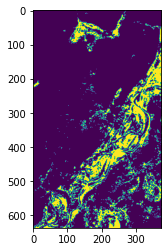

<AxesSubplot:>

In [162]:
show(flood_window)

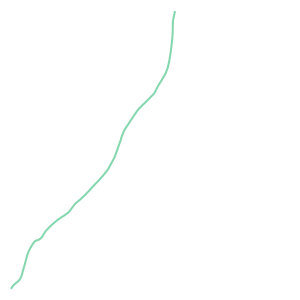

In [165]:
road.geometry

In [164]:
road = roads.iloc[0].copy()

In [143]:
type(road)

pandas.core.series.Series

In [77]:
road.to_file(os.path.join(out_folder, "ROAD_ONE.shp"), driver="ESRI Shapefile")

In [166]:
flood_mask = (flood_window==1)

In [167]:
%%time
allFeatures = []
idx = 0
for cShape, value in features.shapes(flood_window, mask=flood_mask, transform=shifted_affine):
    allFeatures.append([idx, shape(geojson.loads(json.dumps(cShape)))])
    idx+=1
xx_window = pd.DataFrame(allFeatures, columns=['ID', 'geometry'])
xxGeom_window = gpd.GeoDataFrame(xx_window, geometry='geometry')
xxGeom_window.crs = flood.crs

CPU times: user 196 ms, sys: 4 ms, total: 200 ms
Wall time: 199 ms


In [93]:
xx_window = pd.DataFrame(allFeatures, columns=['ID', 'geometry'])
xxGeom_window = gpd.GeoDataFrame(xx_window, geometry='geometry')
xxGeom_window.crs = flood.crs

<AxesSubplot:>

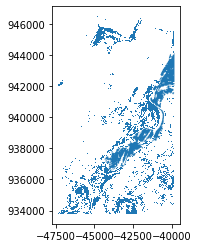

In [168]:
xxGeom_window.plot()

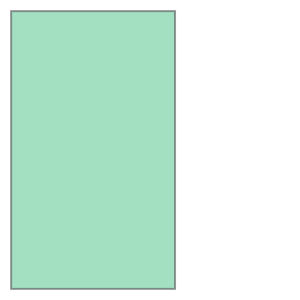

In [120]:
box(road.geometry.bounds[0], road.geometry.bounds[1], road.geometry.bounds[2], road.geometry.bounds[3])

In [122]:
%%time
xxGeom.loc[xxGeom.intersects(box(road.geometry.bounds[0], road.geometry.bounds[1], road.geometry.bounds[2], road.geometry.bounds[3]))]

CPU times: user 2.25 s, sys: 1.92 ms, total: 2.25 s
Wall time: 2.25 s


,ID,geometry
517690,517690,"POLYGON ((-44820.000 946520.000, -44820.000 94..."
517854,517854,"POLYGON ((-41980.000 946480.000, -41980.000 94..."
517919,517919,"POLYGON ((-42000.000 946460.000, -42000.000 94..."
518240,518240,"POLYGON ((-42020.000 946400.000, -42020.000 94..."
518327,518327,"POLYGON ((-44260.000 946360.000, -44260.000 94..."
...,...,...
568767,568767,"POLYGON ((-41660.000 933800.000, -41660.000 93..."
568829,568829,"POLYGON ((-44040.000 933900.000, -44040.000 93..."
569799,569799,"POLYGON ((-43480.000 934900.000, -43480.000 93..."
572614,572614,"POLYGON ((-46420.000 933980.000, -46420.000 93..."


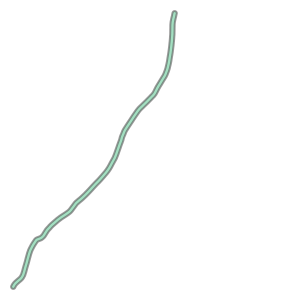

In [84]:
road.geometry.buffer(100)

In [169]:
intersection = road.geometry.intersection(xxGeom_window.unary_union)

In [170]:
intersection.length

3.4840988947840157

In [140]:
road

osm_id                                               10094950
code                                                     5113
fclass                                                primary
name                                          Gogrial - Abyei
ref                                                       B38
oneway                                                      B
maxspeed                                                    0
layer                                                       0
bridge                                                      F
tunnel                                                      F
geometry    LINESTRING (-39848.34631403605 946516.47914786...
Name: 0, dtype: object

In [141]:
road.loc["intersection"] = intersection

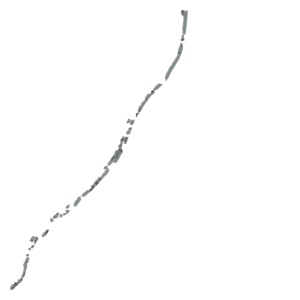

In [89]:
road.geometry.buffer(100).intersection(xxGeom_window.unary_union)

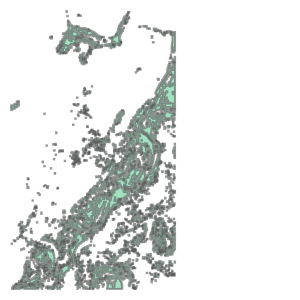

In [123]:
xxGeom_window.unary_union

In [91]:
len(roads)

98229

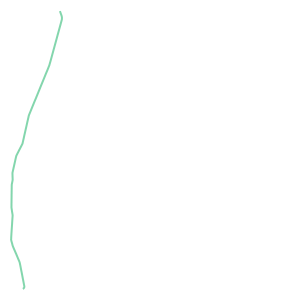

In [173]:
poly

In [195]:
obj = xxGeom_window.unary_union

In [189]:
obj2 = obj.buffer(0)

In [196]:
obj.is_valid

False

In [190]:
obj2.is_valid

True

In [192]:
intersection = road.geometry.intersection(obj2)

In [198]:
if not obj.is_valid:
    print('here')

here


In [201]:
obj.is_valid

True

In [28]:
roads_flooded = []
for idx, road in tqdm(roads.iterrows()):
    
    poly = road.geometry
    # get pixel coordinates of the geometry's bounding box
    ul = flood.index(*poly.bounds[0:2])
    lr = flood.index(*poly.bounds[2:4])
    window = ((float(lr[0]), float(ul[0]+1)), (float(ul[1]), float(lr[1]+1)))
    t = flood.transform
    shifted_affine = Affine(t.a, t.b, t.c+ul[1]*t.a, t.d, t.e, t.f+lr[0]*t.e)
    flood_window = flood.read(1, window=window)
    
    if flood_window.size == 0:
        continue
        
    #Polygonize flood extent
    flood_mask = (flood_window==1)
    allFeatures = []
    idx = 0
    for cShape, value in features.shapes(flood_window, mask=flood_mask, transform=shifted_affine):
        allFeatures.append([idx, shape(geojson.loads(json.dumps(cShape)))])
        idx+=1
    xx_window = pd.DataFrame(allFeatures, columns=['ID', 'geometry'])
    xxGeom_window = gpd.GeoDataFrame(xx_window, geometry='geometry')
    xxGeom_window.crs = flood.crs
    obj = xxGeom_window.unary_union
    if not obj.is_valid:
        obj = obj.buffer(0)
    intersection = road.geometry.intersection(obj)
    if intersection.length > 0:        
        road.loc["intersection"] = intersection
        roads_flooded.append(road)

98229it [1:27:48, 18.64it/s] 


In [29]:
len(roads_flooded)

5638

In [36]:
roads_col = pd.DataFrame(roads_flooded)

In [38]:
roads_col.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,intersection
0,10094950,5113,primary,Gogrial - Abyei,B38,B,0,0,F,F,LINESTRING (-39848.34631403605 946516.47914786...,"LINESTRING (-42878.28055105207 939340, -42880 ..."
4,19752417,5113,primary,Juba-Lainya,None,B,0,0,F,F,LINESTRING (313385.6730357872 500487.064379900...,"(LINESTRING (322234.0802082616 518240, 322240 ..."
5,19753276,5113,primary,Juba-Mundri,A43,B,0,0,F,F,LINESTRING (328647.5429144359 538362.330496970...,"(LINESTRING (329340 538207.5420513997, 329356...."
7,19754176,5113,primary,Nimule Highway,A43,B,0,0,F,F,LINESTRING (348454.8724949403 531777.805444144...,"LINESTRING (348927.4605567445 530540, 348926.8..."
11,19754415,5114,secondary,Juba-Sindiru-Karpeto-Moli,None,B,0,0,F,F,LINESTRING (383812.0118220249 450422.713225380...,"LINESTRING (346980 519837.5798218764, 346955.5..."


In [39]:
roads_col = gpd.GeoDataFrame(roads_col, geometry='intersection', crs=roads.crs)

In [42]:
roads_col.geometry.length.sum()

1066759.9999298002

In [94]:
roads_esri = gpd.read_file(os.path.join(out_folder, "intersection_esri2.shp"))

In [95]:
roads_esri = roads_esri.to_crs(roads.crs)

In [96]:
roads_esri.geometry.length.sum()

1066858.9607908125

In [97]:
allowed_types = ['primary', 'tertiary', 'residential', 'secondary', 'unclassified', 
                 'service', 'track', 'track_grade2', 'track_grade3', 'track_grade4',
                 'pedestrian', 'living_street']

In [98]:
roads_esri = roads_esri.loc[roads_esri.fclass.isin(allowed_types)]

In [99]:
roads_esri.loc[:, "length"] = roads_esri.geometry.length

In [100]:
tab_flood = roads_esri.groupby('ADM2_EN')[['length']].sum()

In [81]:
roads_all = gpd.read_file(os.path.join(out_folder, "roads_all.shp"))

In [82]:
roads_all = roads_all.to_crs(roads.crs)

In [83]:
roads_all = roads_all.loc[roads_all.fclass.isin(allowed_types)]

In [84]:
roads_all.loc[:, "length"] = roads_all.geometry.length

In [85]:
len(roads_all)

42970

In [102]:
tab_all = roads_all.groupby('ADM2_EN')[['length']].sum()

In [108]:
roads_tab = tab_all.join(tab_flood, rsuffix="_flood")

In [109]:
roads_tab.fillna(0, inplace=True)

In [110]:
roads_tab.to_csv(os.path.join(out_folder, "roads_affected.csv"))